In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

In [3]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [3]:
os.listdir(os.path.join(os.getcwd(),"trashnet"))

['plastic', 'glass', 'cardboard', 'paper', '.DS_Store', 'metal', 'trash']

In [5]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [8]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('trashnet',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [25]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

Path('/home/info/Stage_E-Bin/data')

In [26]:
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

In [28]:
tfms = aug_transforms(do_flip=True,flip_vert=True)
data = ImageDataLoaders.from_folder(path,train="train",valid="valid",batch_tfms=tfms,bs=16)


/home/info/anaconda3/envs/stageEbin/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630742027/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [29]:
data

In [34]:
data.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

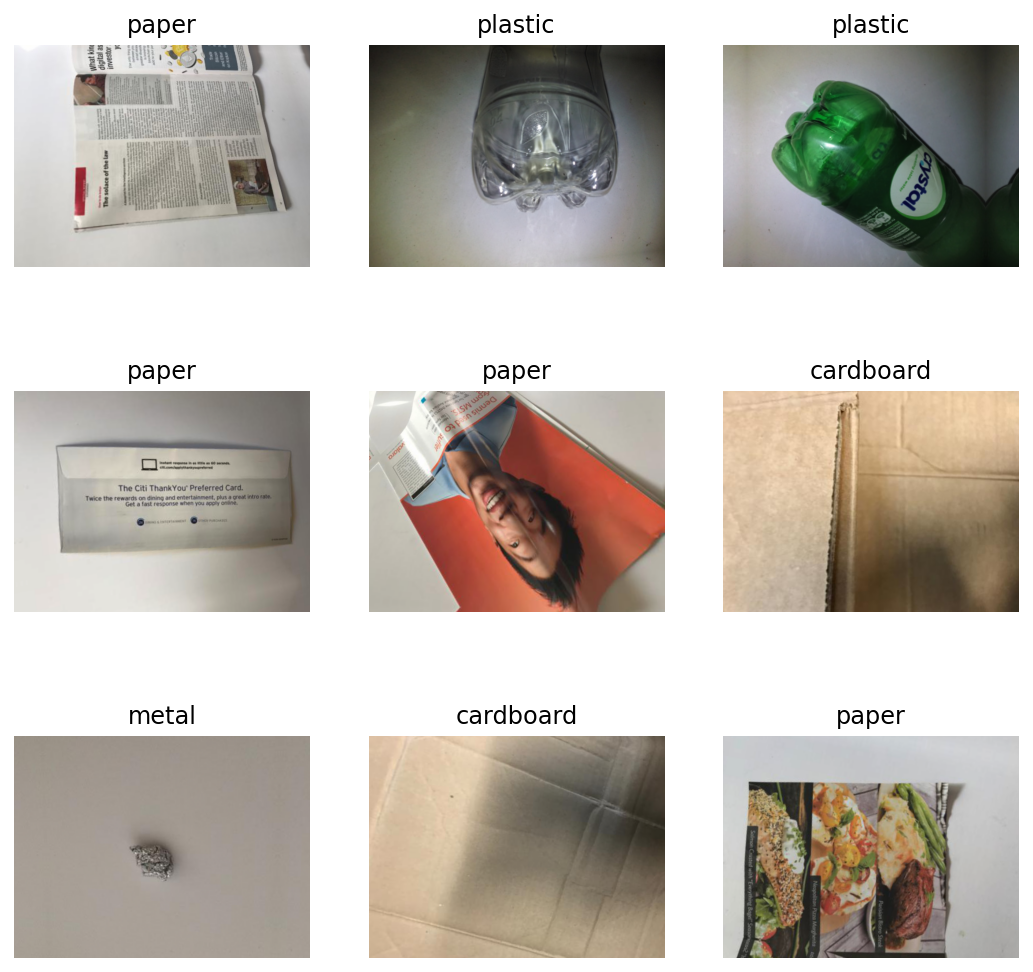

In [36]:
data.show_batch()

In [38]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/info/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

SuggestedLRs(valley=0.0012022644514217973)

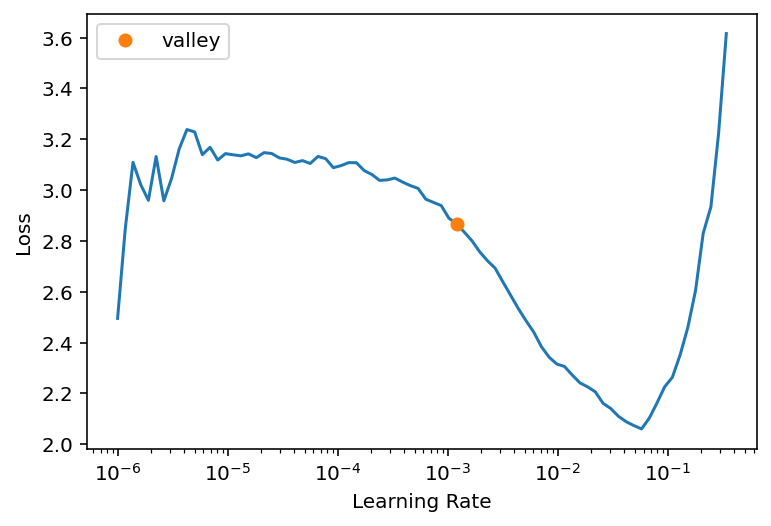

In [41]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
#learn.recorder.plot()

In [45]:
lr=0.0012022644514217973
learn.fit_one_cycle(30,slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.328886,0.270459,0.092063,00:54
1,0.255339,0.265137,0.092063,00:54
2,0.274375,0.280118,0.085714,00:54
3,0.284422,0.284025,0.092063,00:55
4,0.286091,0.290411,0.095238,00:54
5,0.297206,0.332719,0.090476,00:54
6,0.304227,0.350428,0.103175,00:54
7,0.326651,0.311200,0.093651,00:54
8,0.266115,0.318369,0.098413,00:54
9,0.309702,0.351723,0.104762,00:54


In [46]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

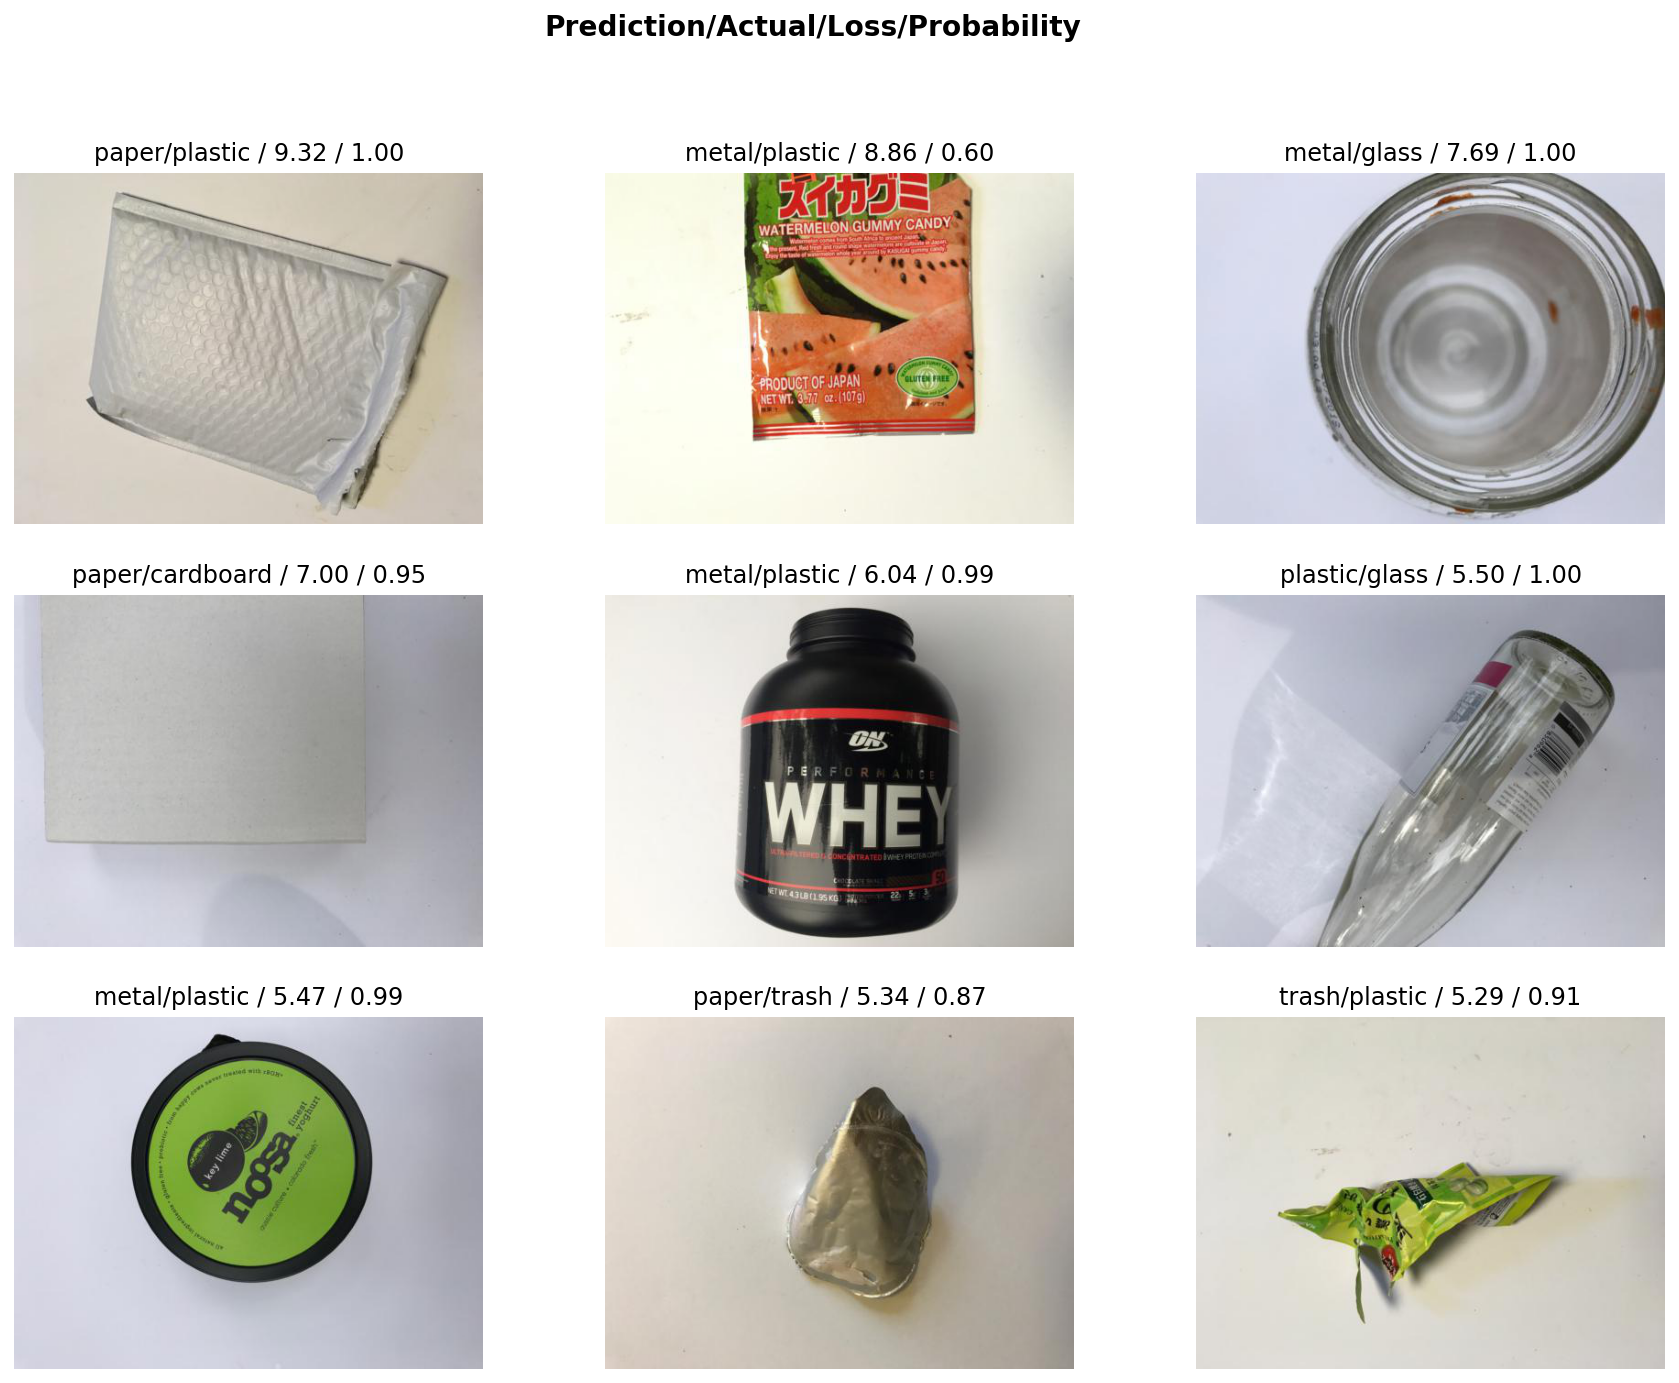

In [47]:
interp.plot_top_losses(9, figsize=(15,11))

Interpretation.plot_top_losses(k, largest=True, **kwargs)
None

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


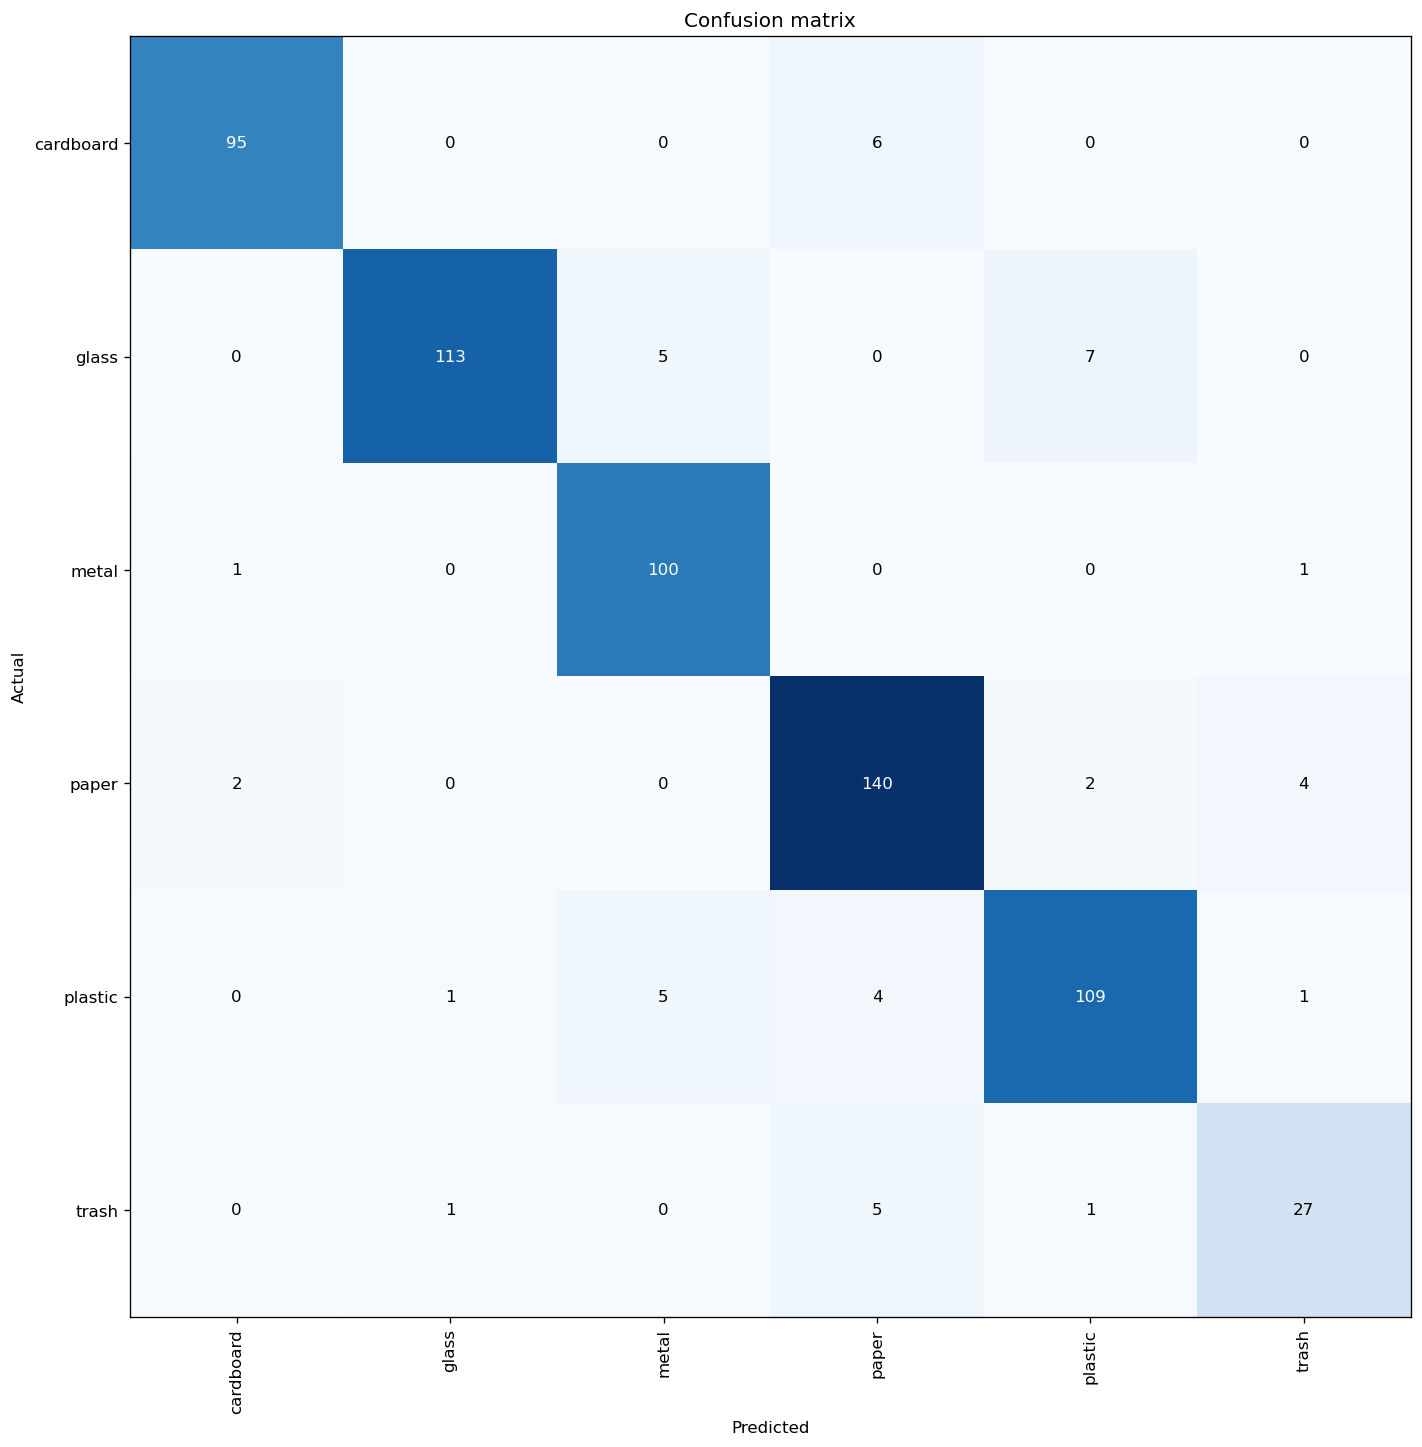

In [48]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 7),
 ('cardboard', 'paper', 6),
 ('glass', 'metal', 5),
 ('plastic', 'metal', 5),
 ('trash', 'paper', 5),
 ('paper', 'trash', 4),
 ('plastic', 'paper', 4),
 ('paper', 'cardboard', 2),
 ('paper', 'plastic', 2)]

In [66]:
testpath = Path('data/test')
imgs = get_image_files(testpath)
dl = learn.dls.test_dl(learn.dls, imgs)

AssertionError: Match length mismatch

In [68]:
torch.save(learn.model.state_dict(), Path('trashnet_fastai_model/myModel.pth'))



In [70]:
learn.export(os.path.abspath('./my_export.pkl'))